In [1]:
import pandas as pd
import numpy as np
import scipy.stats 

In [2]:
import yfinance as yf

ticker = yf.Ticker("AAPL")

exp_date = ticker.options[0]
opt_chain = ticker.option_chain(exp_date)
calls = opt_chain.calls

(calls["ask"]-calls["bid"]).mean(), (calls["ask"]-calls["bid"]).median()

(np.float64(0.2915714285714287), np.float64(0.010000000000000009))

In [3]:
options_df = pd.read_csv("../data/options_cleaned.csv")

# options_df["riskfree_rate"] = options_df["riskfree_rate"]/100

options_df

,strike,stockClosePrice,deltaT_years,riskfree_rate,isCall,volume,openInterest,impliedVolatility,inTheMoney,isNVDA,lastPrice
0,110.0,211.160004,0.000162,0.0437,1,59.0,151.0,6.593752,True,0,101.30
1,120.0,213.550003,0.022297,0.0435,1,4.0,7.0,5.808596,True,0,93.55
2,130.0,198.419998,0.069249,0.0424,1,4.0,4.0,5.230472,True,0,67.25
3,135.0,201.080002,0.038946,0.0419,1,1.0,1.0,4.414067,True,0,66.30
4,140.0,211.139999,0.005615,0.0436,1,1.0,4.0,4.658207,True,0,70.03
...,...,...,...,...,...,...,...,...,...,...,...
29075,895.0,593.096619,2.581683,0.0437,0,2.0,0.0,0.000010,True,0,304.90
29076,900.0,625.340027,2.458075,0.0435,0,10.0,0.0,0.137155,True,0,274.31
29077,905.0,609.290466,2.825038,0.0438,0,0.0,0.0,0.357016,True,0,293.10
29078,910.0,607.119995,2.479632,0.0421,0,1.0,0.0,0.140374,True,0,303.38


In [4]:
options_df["lastPrice"].max()

np.float64(1209.78)

In [5]:
full_options_df = pd.read_csv("../data/options_withriskfreerates_andDeltaT.csv")

options_df["stockTicker"] = full_options_df["stockTicker"]

In [6]:
options_df["inTheMoney"] = full_options_df["inTheMoney"]

In [7]:
options_df["impliedVolatility"].min()

np.float64(0.0)

In [8]:
def BlackScholesModel(S,K,r,dT,sigma,isCall):
    """
    Computes the theoretical price of a European option using the Black-Scholes model.

    Parameters
    ----------
    S : float
        Current stock price (spot price).
    K : float
        Strike price of the option.
    r : float
        Risk-free interest rate (annualized, continuously compounded).
    dT : float
        Time to maturity in years (e.g., 0.5 for 6 months).
    sigma : float
        Volatility of the underlying stock (annualized standard deviation).
    isCall : bool
        If True, calculates the price of a call option; if False, calculates the price of a put option.

    Returns
    -------
    float
        The Black-Scholes price of the European call or put option.
        Returns NaN if any of the inputs are invalid (e.g., non-positive S, K, dT, or sigma).

    """

    if dT <= 0 or sigma < 0 or S <= 0 or K <= 0:
        return np.nan  
    
    if sigma == 0:
        if isCall:
            return max(S - K, 0)
        else:
            return max(K - S, 0)

    d_plus = 1/(sigma*np.sqrt(dT))* ( np.log(S/K) + (r + sigma**2/2)*dT )
    d_minus = d_plus - sigma*np.sqrt(dT)

    if isCall:
        option_price = scipy.stats.norm.cdf(d_plus)*S - scipy.stats.norm.cdf(d_minus)*K*np.exp(-r*dT)
    else:
        option_price = scipy.stats.norm.cdf(-d_minus)*K*np.exp(-r*dT) - scipy.stats.norm.cdf(-d_plus)*S
    
    return option_price

In [9]:
options_df.loc[options_df["impliedVolatility"]==0,:]

,strike,stockClosePrice,deltaT_years,riskfree_rate,isCall,volume,openInterest,impliedVolatility,inTheMoney,isNVDA,lastPrice,stockTicker
1697,390.0,95.348045,1.332018,0.0550,1,10.0,14.0,0.0,False,1,594.58,NVDA
1698,400.0,114.954247,1.296331,0.0549,1,1.0,7.0,0.0,False,1,765.13,NVDA
1699,450.0,94.912216,1.329512,0.0549,1,1.0,1.0,0.0,False,1,542.09,NVDA
1700,470.0,122.391281,1.290734,0.0548,1,1.0,2.0,0.0,False,1,779.15,NVDA
1701,500.0,120.839897,1.285266,0.0547,1,1.0,16.0,0.0,False,1,761.66,NVDA
...,...,...,...,...,...,...,...,...,...,...,...,...
5112,30.0,227.500000,0.740300,0.0435,1,1.0,160.0,0.0,True,0,197.00,TSLA
5538,30.0,227.500000,1.411530,0.0435,1,0.0,0.0,0.0,True,0,197.00,TSLA
5741,20.0,285.880005,1.718089,0.0435,1,1.0,64.0,0.0,True,0,265.39,TSLA
5742,25.0,250.740005,1.732376,0.0433,1,1.0,216.0,0.0,True,0,227.60,TSLA


In [10]:
stock_price = options_df["stockClosePrice"]
strike_price = options_df["strike"]
riskfree_rate = options_df["riskfree_rate"]
time_to_expiry = options_df["deltaT_years"]
volatility = options_df["impliedVolatility"]
isCall = options_df["isCall"]

options_df["calculated_price"] = None


# options_df["calculated_price"] = BlackScholesModel(stock_price,strike_price,riskfree_rate,time_to_expiry,volatility,isCall)

for i in range(len(options_df)):
    options_df.loc[i,"calculated_price"] = BlackScholesModel(stock_price[i],strike_price[i],riskfree_rate[i],time_to_expiry[i],volatility[i],isCall[i])

In [11]:
options_df.isna().sum()

strike               0
stockClosePrice      0
deltaT_years         0
riskfree_rate        0
isCall               0
volume               0
openInterest         0
impliedVolatility    0
inTheMoney           0
isNVDA               0
lastPrice            0
stockTicker          0
calculated_price     0
dtype: int64

In [12]:
error = (options_df["calculated_price"]- options_df["lastPrice"])/options_df["lastPrice"]*100

In [13]:
error[np.abs(error)>10]
# error[error<0]

1        21.441987
2        80.141031
3        43.478867
6        38.098559
7        24.875992
           ...    
29074   -20.366496
29075   -32.299945
29076   -30.002654
29078   -27.844425
29079   -28.283195
Length: 17191, dtype: object

In [14]:
error.median()

np.float64(0.05583325535044008)

(array([2.8965e+04, 4.8000e+01, 2.3000e+01, 2.0000e+01, 1.0000e+01,
        4.0000e+00, 3.0000e+00, 1.0000e+00, 4.0000e+00, 2.0000e+00]),
 array([-1.00000000e+02,  3.67066850e+04,  7.35133699e+04,  1.10320055e+05,
         1.47126740e+05,  1.83933425e+05,  2.20740110e+05,  2.57546795e+05,
         2.94353480e+05,  3.31160165e+05,  3.67966850e+05]),
 <BarContainer object of 10 artists>)

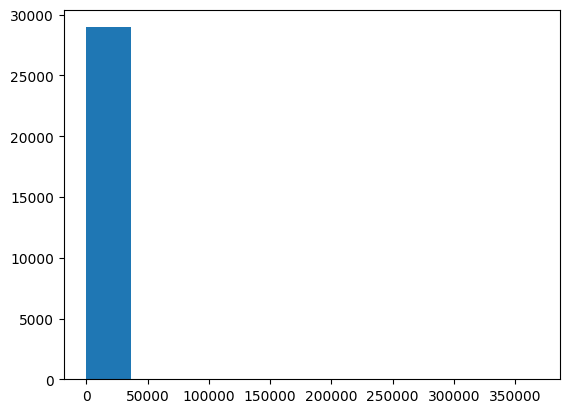

In [15]:
import matplotlib.pyplot as plt

plt.hist(error)

In [16]:
options_df.loc[options_df["stockTicker"]=="NVDA","lastPrice"].max()

np.float64(1209.78)

In [17]:
options_df["deltaT_years"]

0        0.000162
1        0.022297
2        0.069249
3        0.038946
4        0.005615
           ...   
29075    2.581683
29076    2.458075
29077    2.825038
29078    2.479632
29079    2.438592
Name: deltaT_years, Length: 29080, dtype: float64

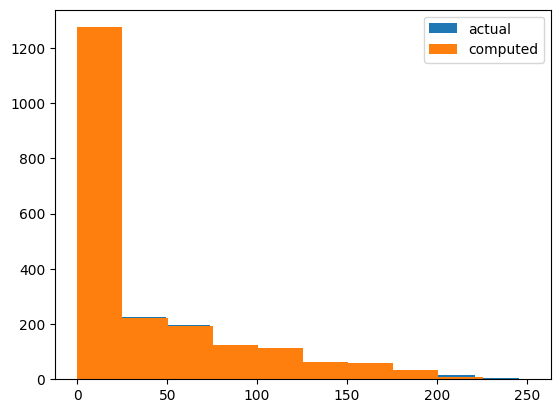

In [18]:
# plt.plot(options_df.loc[options_df["stockTicker"]=="AAPL","delt"],options_df.loc[options_df["stockTicker"]=="AAPL","lastPrice"], ".")
plt.hist(options_df.loc[options_df["stockTicker"]=="AAPL","lastPrice"],label="actual")
plt.hist(options_df.loc[options_df["stockTicker"]=="AAPL","calculated_price"],label="computed")
plt.legend()

In [19]:
options_df.columns

Index(['strike', 'stockClosePrice', 'deltaT_years', 'riskfree_rate', 'isCall',
       'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'isNVDA',
       'lastPrice', 'stockTicker', 'calculated_price'],
      dtype='object')

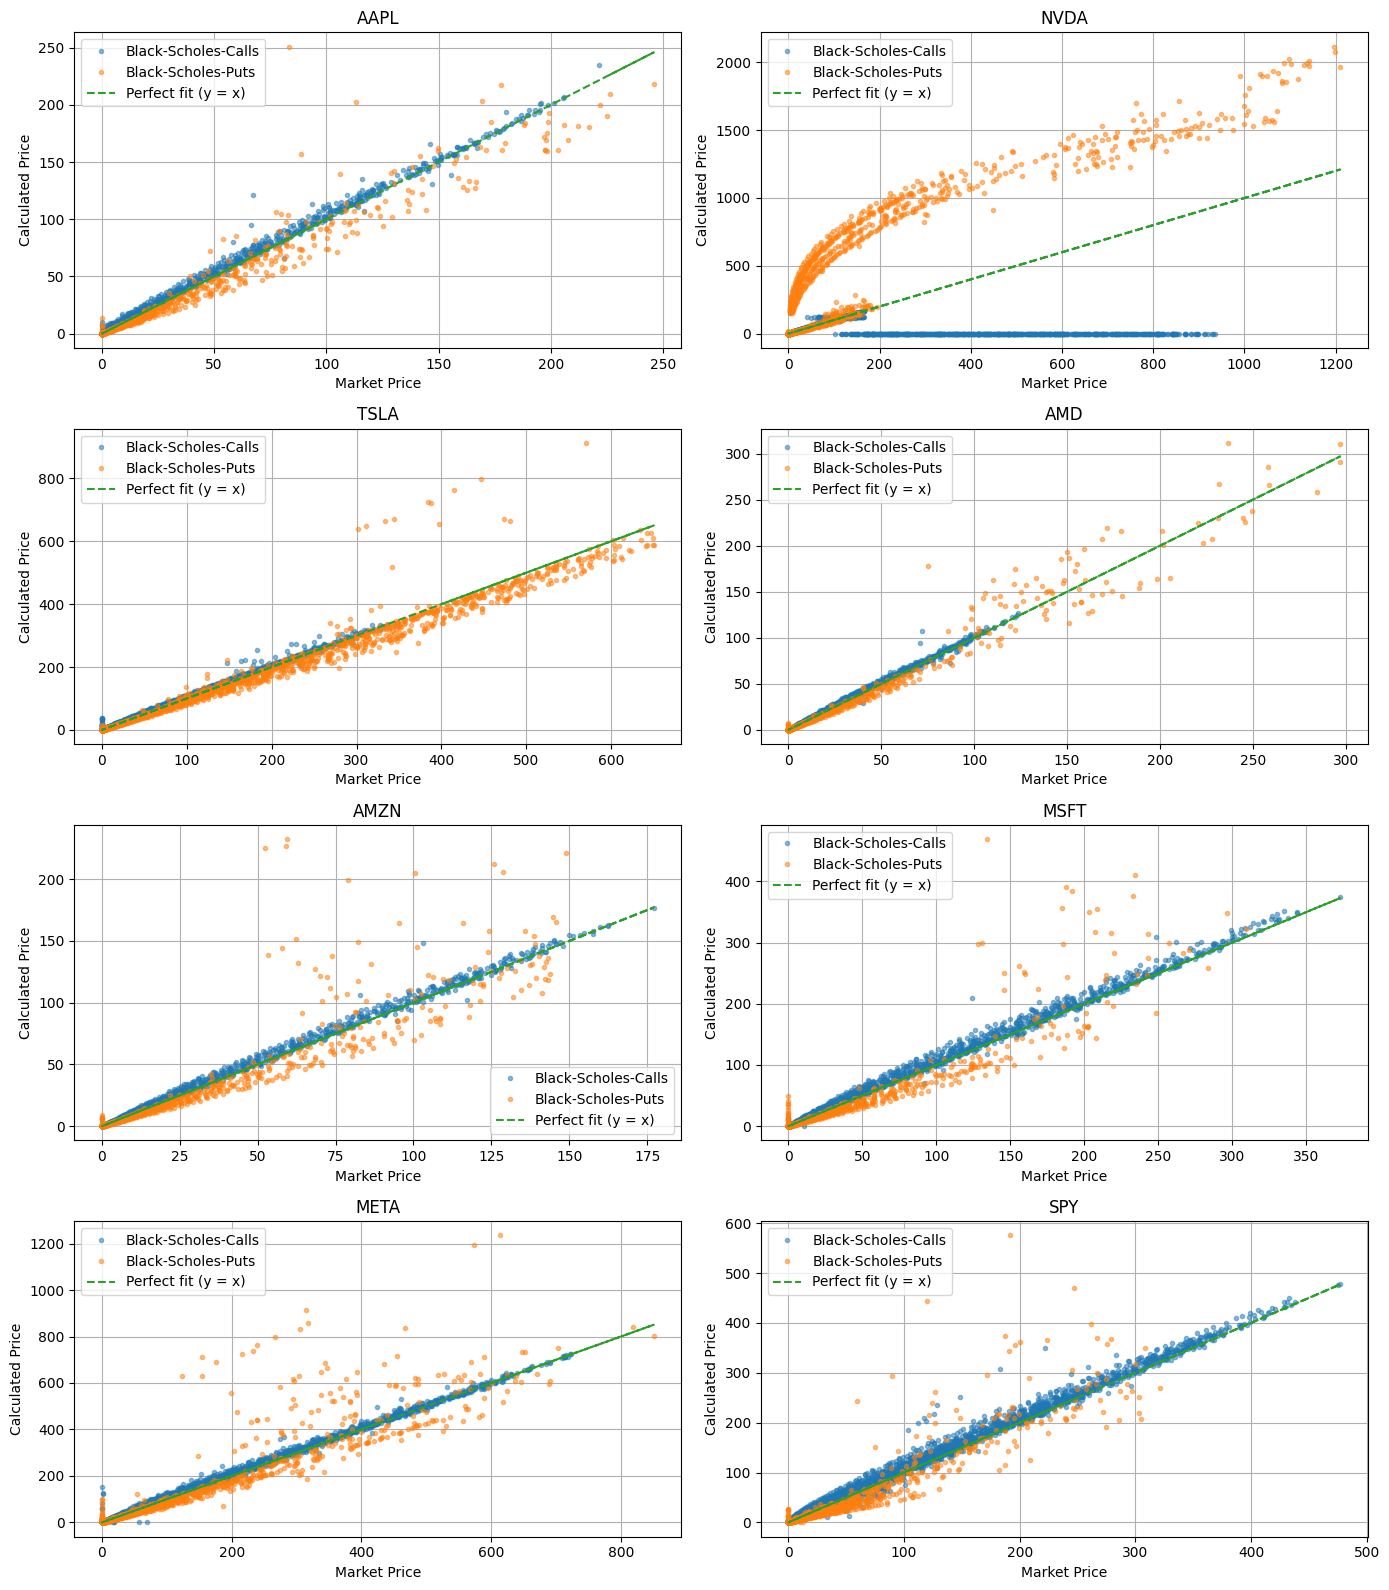

In [20]:
tickers = ["AAPL","NVDA","TSLA","AMD","AMZN","MSFT","META","SPY"]

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()  # Flatten to easily index with a loop

for i, ticker in enumerate(tickers):
    ax = axes[i]
    df = options_df[options_df["stockTicker"] == ticker]

    ax.plot(df.loc[df["isCall"]==1,"lastPrice"], df.loc[df["isCall"]==1,"calculated_price"], ".", label="Black-Scholes-Calls",alpha=0.5)
    ax.plot(df.loc[df["isCall"]==0,"lastPrice"], df.loc[df["isCall"]==0,"calculated_price"], ".", label="Black-Scholes-Puts",alpha=0.5)
    ax.plot(df["lastPrice"], df["lastPrice"], "--", label="Perfect fit (y = x)")
    ax.set_title(f"{ticker}")
    ax.set_xlabel("Market Price")
    ax.set_ylabel("Calculated Price")
    ax.legend()
    ax.grid(True)

plt.tight_layout()

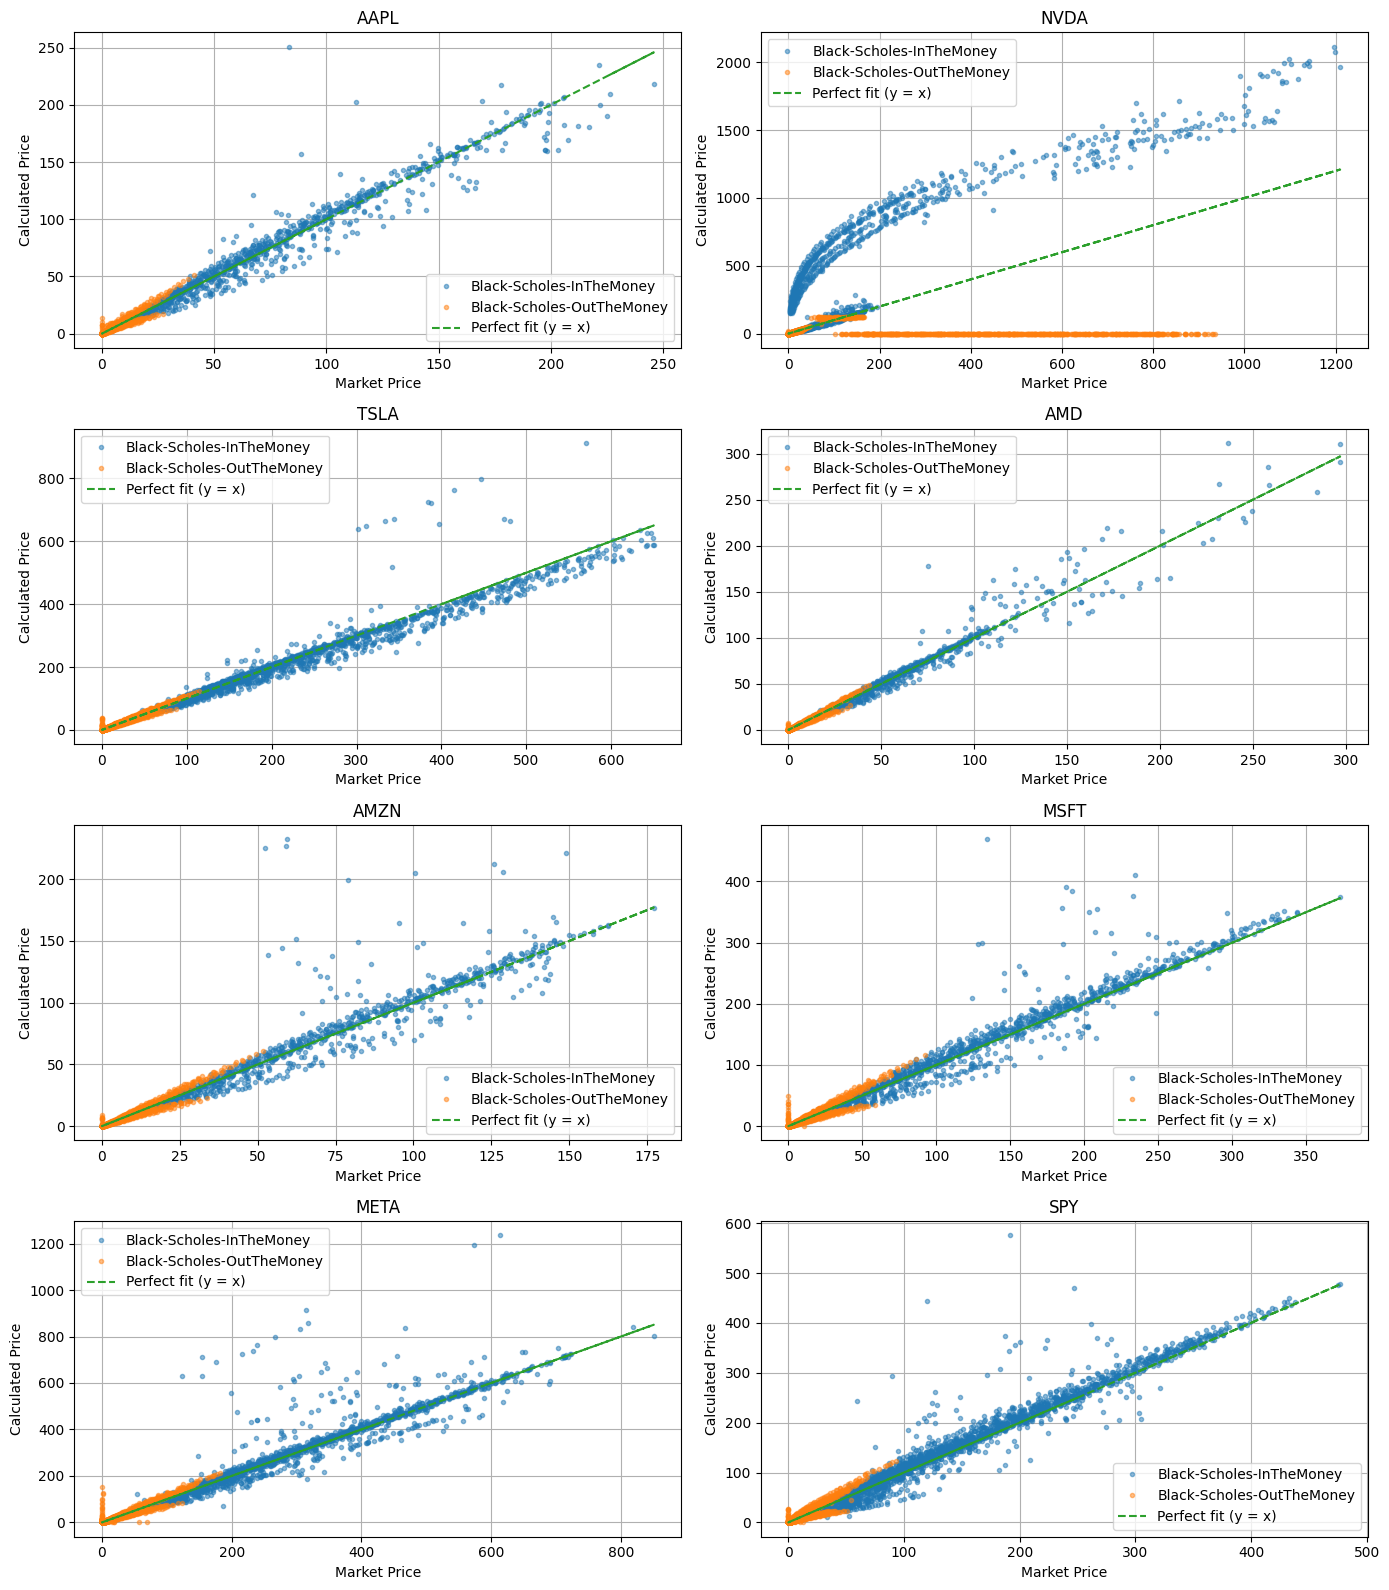

In [21]:
tickers = ["AAPL","NVDA","TSLA","AMD","AMZN","MSFT","META","SPY"]

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()  # Flatten to easily index with a loop

for i, ticker in enumerate(tickers):
    ax = axes[i]
    df = options_df[options_df["stockTicker"] == ticker]

    ax.plot(df.loc[df["inTheMoney"]==1,"lastPrice"], df.loc[df["inTheMoney"]==1,"calculated_price"], ".", label="Black-Scholes-InTheMoney",alpha=0.5)
    ax.plot(df.loc[df["inTheMoney"]==0,"lastPrice"], df.loc[df["inTheMoney"]==0,"calculated_price"], ".", label="Black-Scholes-OutTheMoney",alpha=0.5)
    ax.plot(df["lastPrice"], df["lastPrice"], "--", label="Perfect fit (y = x)")
    ax.set_title(f"{ticker}")
    ax.set_xlabel("Market Price")
    ax.set_ylabel("Calculated Price")
    ax.legend()
    ax.grid(True)

plt.tight_layout()

Text(0.5, 0, 'Implied Volatility ($\\sigma$)')

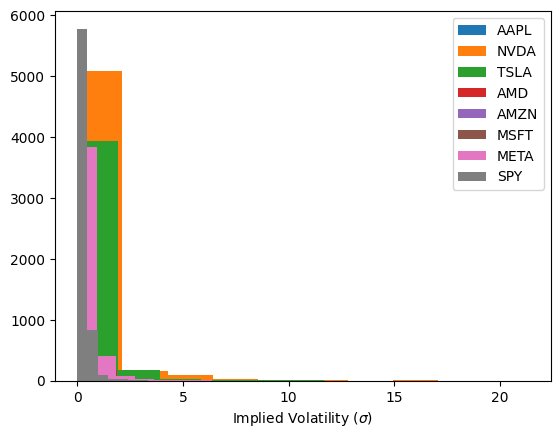

In [22]:
for ticker in tickers:
    df = options_df[options_df["stockTicker"] == ticker]

    plt.hist(df["impliedVolatility"],label=ticker)

plt.legend()
plt.xlabel("Implied Volatility ($\sigma$)")

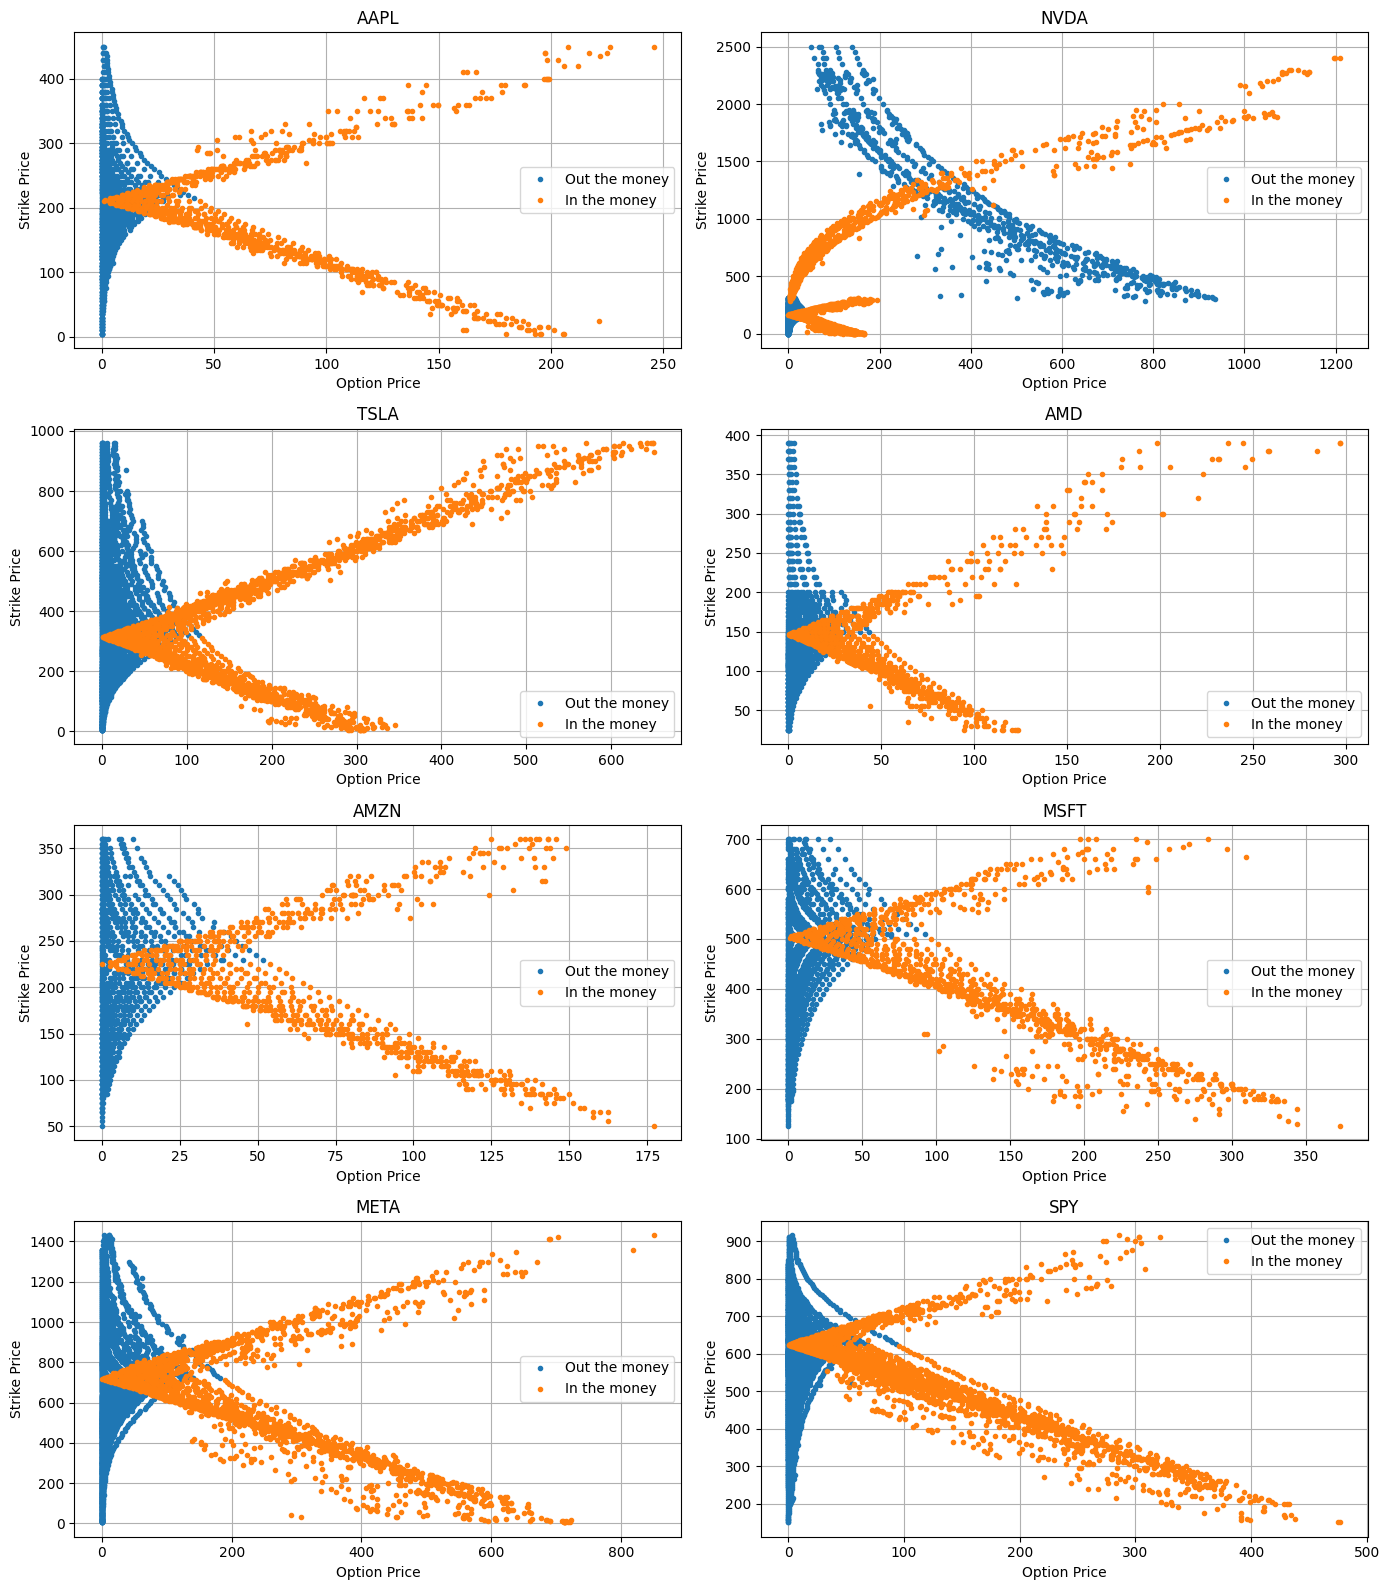

In [23]:
tickers = ["AAPL","NVDA","TSLA","AMD","AMZN","MSFT","META","SPY"]

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()  # Flatten to easily index with a loop

for i, ticker in enumerate(tickers):
    ax = axes[i]
    df = options_df[options_df["stockTicker"] == ticker]

    # df = df[df["lastPrice"]==0.01]

    # ax.plot(df["lastPrice"], df["strike"], ".", label="Strike")
    ax.plot(df.loc[df["inTheMoney"]==0,"lastPrice"], df.loc[df["inTheMoney"]==0,"strike"], ".", label="Out the money")
    ax.plot(df.loc[df["inTheMoney"]==1,"lastPrice"], df.loc[df["inTheMoney"]==1,"strike"], ".", label="In the money")
    # ax.plot(df["lastPrice"], df["lastPrice"], "--", label="Perfect fit (y = x)")
    ax.set_title(f"{ticker}")
    ax.set_xlabel("Option Price")
    ax.set_ylabel("Strike Price")
    ax.legend()
    ax.grid(True)

plt.tight_layout()

In [24]:
def binomial_american_option(S, K, r, dT, sigma, isCall, div_yield=0.0, steps=100):
    """
    Prices an American option using the Cox-Ross-Rubinstein (CRR) binomial tree model.

    Parameters
    ----------
    S : float
        Current stock price (spot price).
    K : float
        Strike price of the option.
    r : float
        Risk-free interest rate (annualized, continuously compounded).
    dT : float
        Time to maturity in years.
    sigma : float
        Volatility of the underlying stock (annualized).
    isCall : bool
        True for call option, False for put option.
    div_yield : float, optional
        Continuous dividend yield (default 0.0).
    steps : int, optional
        Number of time steps in the binomial tree (default 100).

    Returns
    -------
    float
        The American option price.
    """

    if sigma <= 0 or dT <= 0 or steps <= 0:
        return np.nan

    dt = dT / steps
    discount = np.exp(-r * dt)

    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u

    p = (np.exp((r - div_yield) * dt) - d) / (u - d)
    p = np.clip(p, 0, 1)

    asset_prices = np.array([S * (u ** j) * (d ** (steps - j)) for j in range(steps + 1)])

    if isCall:
        option_values = np.maximum(asset_prices - K, 0)
    else:
        option_values = np.maximum(K - asset_prices, 0)

    if np.any(np.isnan(option_values)) or np.any(np.isinf(option_values)):
        raise ValueError("NaN or Inf found in initial option values")

    for i in range(steps - 1, -1, -1):
        asset_prices = asset_prices[:i+1] * d
        option_values = discount * (p * option_values[1:i+2] + (1 - p) * option_values[:i+1])
        if isCall:
            option_values = np.maximum(option_values, asset_prices - K)
        else:
            option_values = np.maximum(option_values, K - asset_prices)

    return option_values[0]


In [25]:
options_df["calculated_price_binomial"] = None

for i in range(len(options_df)):
    options_df.loc[i,"calculated_price_binomial"] = binomial_american_option(stock_price[i],strike_price[i],riskfree_rate[i],time_to_expiry[i],volatility[i],isCall[i],steps=200)

In [26]:
error_binomial = np.abs(options_df["calculated_price_binomial"]- options_df["lastPrice"])/options_df["lastPrice"]*100

<Axes: ylabel='Frequency'>

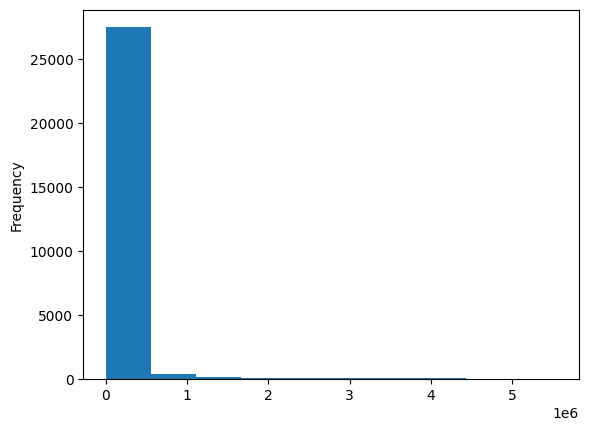

In [27]:
error_binomial.plot(kind="hist")

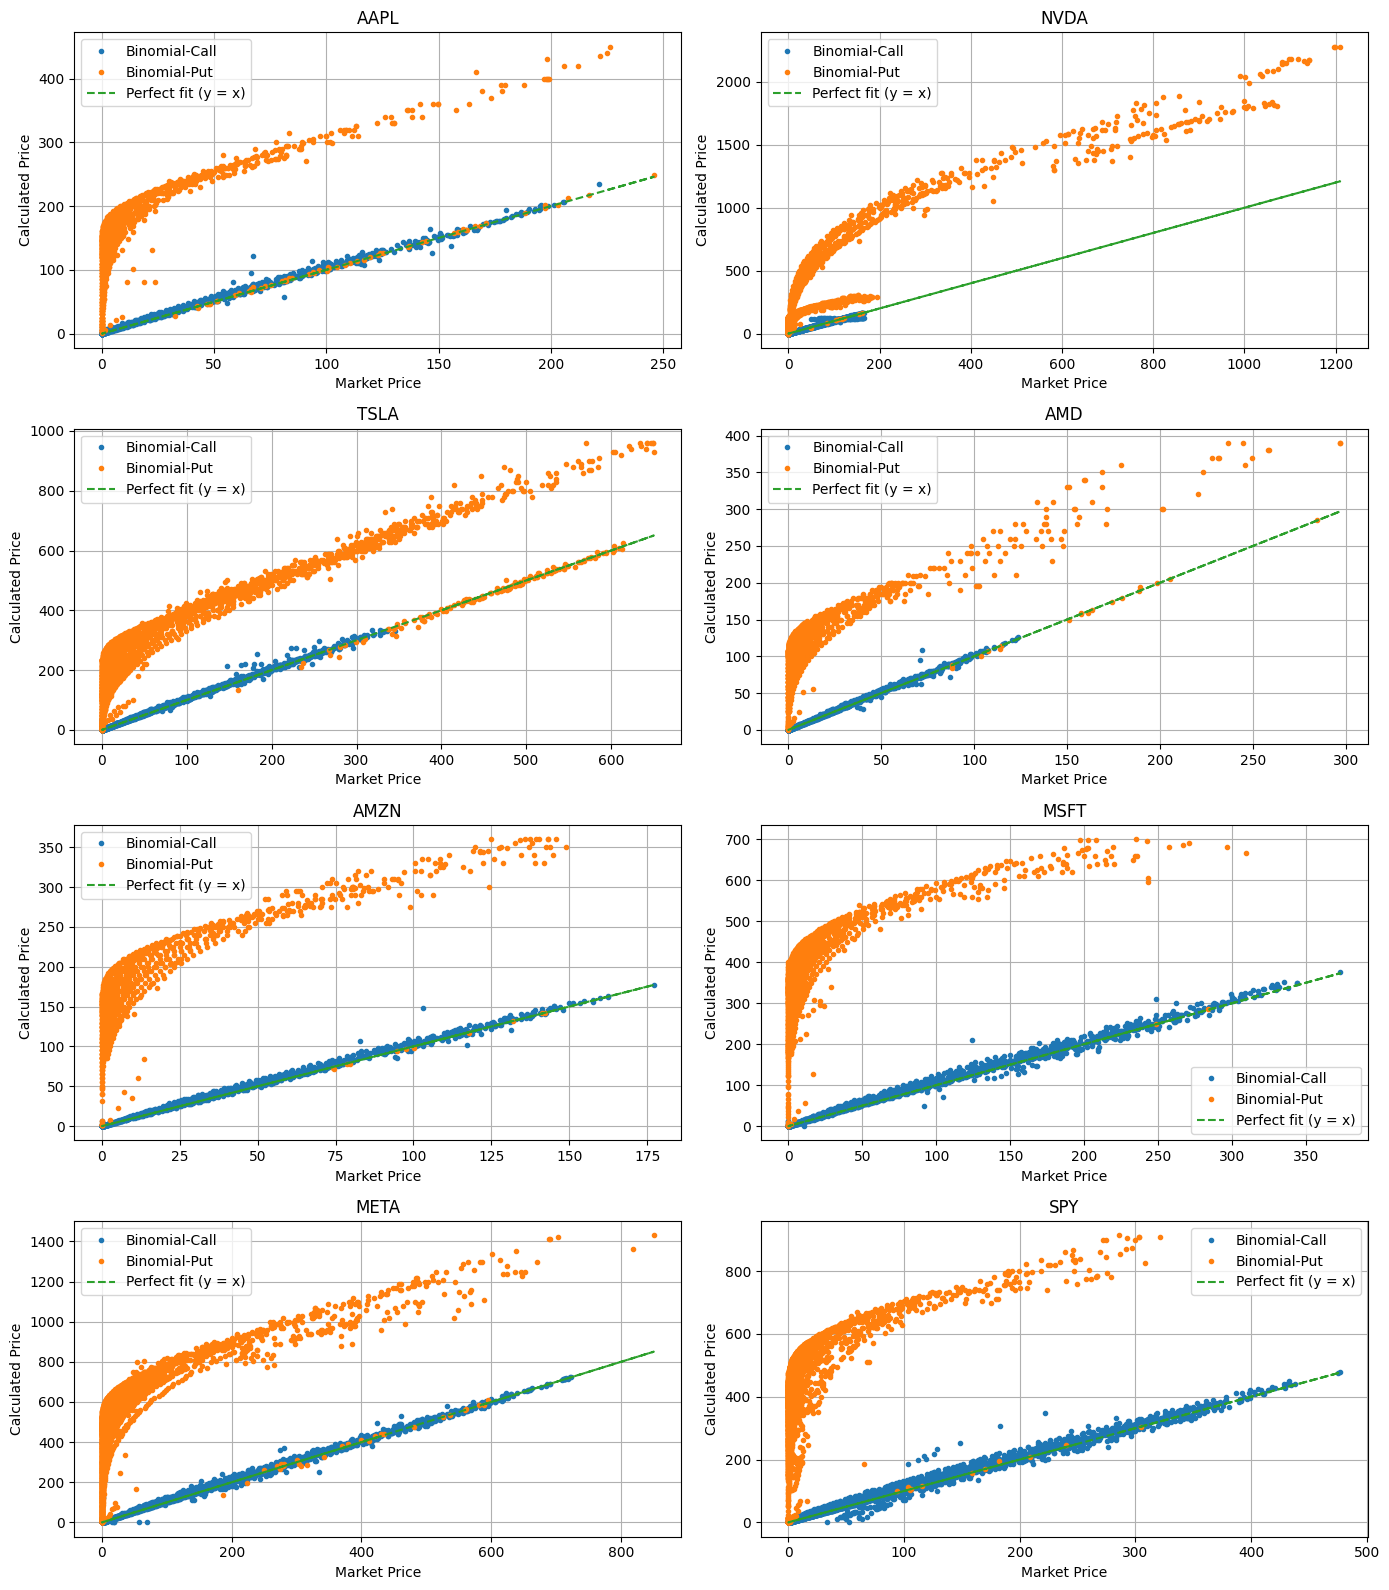

In [28]:
tickers = ["AAPL","NVDA","TSLA","AMD","AMZN","MSFT","META","SPY"]

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()  # Flatten to easily index with a loop

for i, ticker in enumerate(tickers):
    ax = axes[i]
    df = options_df[options_df["stockTicker"] == ticker]

    ax.plot(df.loc[df["isCall"]==1,"lastPrice"], df.loc[df["isCall"]==1,"calculated_price_binomial"], ".", label="Binomial-Call")
    ax.plot(df.loc[df["isCall"]==0,"lastPrice"], df.loc[df["isCall"]==0,"calculated_price_binomial"], ".", label="Binomial-Put")
    ax.plot(df["lastPrice"], df["lastPrice"], "--", label="Perfect fit (y = x)")
    ax.set_title(f"{ticker}")
    ax.set_xlabel("Market Price")
    ax.set_ylabel("Calculated Price")
    ax.legend()
    ax.grid(True)

plt.tight_layout()

In [29]:
import yfinance as yf

tickers = ["AAPL","NVDA","TSLA","AMD","AMZN","MSFT","META","SPY"]

for ticker in tickers:

    yfticker = yf.Ticker(ticker)  # Replace with your stock ticker
    dividends = yfticker.dividends

    print(ticker)
    print(dividends.tail())

AAPL
Date
2024-05-10 00:00:00-04:00    0.25
2024-08-12 00:00:00-04:00    0.25
2024-11-08 00:00:00-05:00    0.25
2025-02-10 00:00:00-05:00    0.25
2025-05-12 00:00:00-04:00    0.26
Name: Dividends, dtype: float64
NVDA
Date
2024-06-11 00:00:00-04:00    0.01
2024-09-12 00:00:00-04:00    0.01
2024-12-05 00:00:00-05:00    0.01
2025-03-12 00:00:00-04:00    0.01
2025-06-11 00:00:00-04:00    0.01
Name: Dividends, dtype: float64
TSLA
Series([], Name: Dividends, dtype: float64)
AMD
Series([], Name: Dividends, dtype: float64)
AMZN
Series([], Name: Dividends, dtype: float64)
MSFT
Date
2024-05-15 00:00:00-04:00    0.75
2024-08-15 00:00:00-04:00    0.75
2024-11-21 00:00:00-05:00    0.83
2025-02-20 00:00:00-05:00    0.83
2025-05-15 00:00:00-04:00    0.83
Name: Dividends, dtype: float64
META
Date
2024-06-14 00:00:00-04:00    0.500
2024-09-16 00:00:00-04:00    0.500
2024-12-16 00:00:00-05:00    0.500
2025-03-14 00:00:00-04:00    0.525
2025-06-16 00:00:00-04:00    0.525
Name: Dividends, dtype: float64
S

In [30]:
nvidia_options = options_df.loc[options_df["stockTicker"]=="NVDA",:]

nvidia_options.loc[nvidia_options["isCall"]==1, "inTheMoney"].value_counts()

inTheMoney
False    1473
True     1336
Name: count, dtype: int64

Puts:
inTheMoney
False    1347
True     1222
Name: count, dtype: int64

Calls:
inTheMoney
False    1473
True     1336
Name: count, dtype: int64

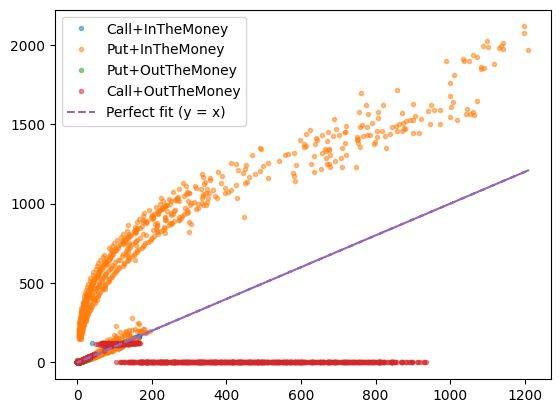

In [31]:
# nvidia_options.loc[(nvidia_options["isCall"] == 1) & (nvidia_options["inTheMoney"] == 1), "lastPrice"]

plt.plot(nvidia_options.loc[(nvidia_options["isCall"] == 1) & (nvidia_options["inTheMoney"] == 1), "lastPrice"],nvidia_options.loc[(nvidia_options["isCall"] == 1) & (nvidia_options["inTheMoney"] == 1), "calculated_price"],'.',label="Call+InTheMoney",alpha=0.5)
plt.plot(nvidia_options.loc[(nvidia_options["isCall"] == 0) & (nvidia_options["inTheMoney"] == 1), "lastPrice"],nvidia_options.loc[(nvidia_options["isCall"] == 0) & (nvidia_options["inTheMoney"] == 1), "calculated_price"],'.',label="Put+InTheMoney",alpha=0.5)
plt.plot(nvidia_options.loc[(nvidia_options["isCall"] == 0) & (nvidia_options["inTheMoney"] == 0), "lastPrice"],nvidia_options.loc[(nvidia_options["isCall"] == 0) & (nvidia_options["inTheMoney"] == 0), "calculated_price"],'.',label="Put+OutTheMoney",alpha=0.5)
plt.plot(nvidia_options.loc[(nvidia_options["isCall"] == 1) & (nvidia_options["inTheMoney"] == 0), "lastPrice"],nvidia_options.loc[(nvidia_options["isCall"] == 1) & (nvidia_options["inTheMoney"] == 0), "calculated_price"],'.',label="Call+OutTheMoney",alpha=0.5)
plt.plot(nvidia_options["lastPrice"], nvidia_options["lastPrice"], "--", label="Perfect fit (y = x)")
plt.legend()

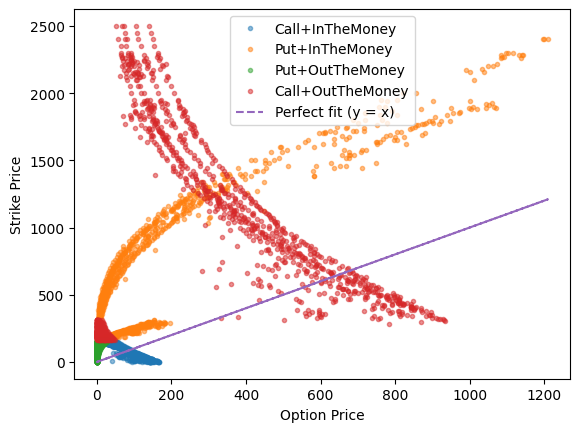

In [32]:
# nvidia_options.loc[(nvidia_options["isCall"] == 1) & (nvidia_options["inTheMoney"] == 1), "lastPrice"]

plt.plot(nvidia_options.loc[(nvidia_options["isCall"] == 1) & (nvidia_options["inTheMoney"] == 1), "lastPrice"],nvidia_options.loc[(nvidia_options["isCall"] == 1) & (nvidia_options["inTheMoney"] == 1), "strike"],'.',label="Call+InTheMoney",alpha=0.5)
plt.plot(nvidia_options.loc[(nvidia_options["isCall"] == 0) & (nvidia_options["inTheMoney"] == 1), "lastPrice"],nvidia_options.loc[(nvidia_options["isCall"] == 0) & (nvidia_options["inTheMoney"] == 1), "strike"],'.',label="Put+InTheMoney",alpha=0.5)
plt.plot(nvidia_options.loc[(nvidia_options["isCall"] == 0) & (nvidia_options["inTheMoney"] == 0), "lastPrice"],nvidia_options.loc[(nvidia_options["isCall"] == 0) & (nvidia_options["inTheMoney"] == 0), "strike"],'.',label="Put+OutTheMoney",alpha=0.5)
plt.plot(nvidia_options.loc[(nvidia_options["isCall"] == 1) & (nvidia_options["inTheMoney"] == 0), "lastPrice"],nvidia_options.loc[(nvidia_options["isCall"] == 1) & (nvidia_options["inTheMoney"] == 0), "strike"],'.',label="Call+OutTheMoney",alpha=0.5)
plt.plot(nvidia_options["lastPrice"], nvidia_options["lastPrice"], "--", label="Perfect fit (y = x)")
plt.xlabel("Option Price")
plt.ylabel("Strike Price")
plt.legend()

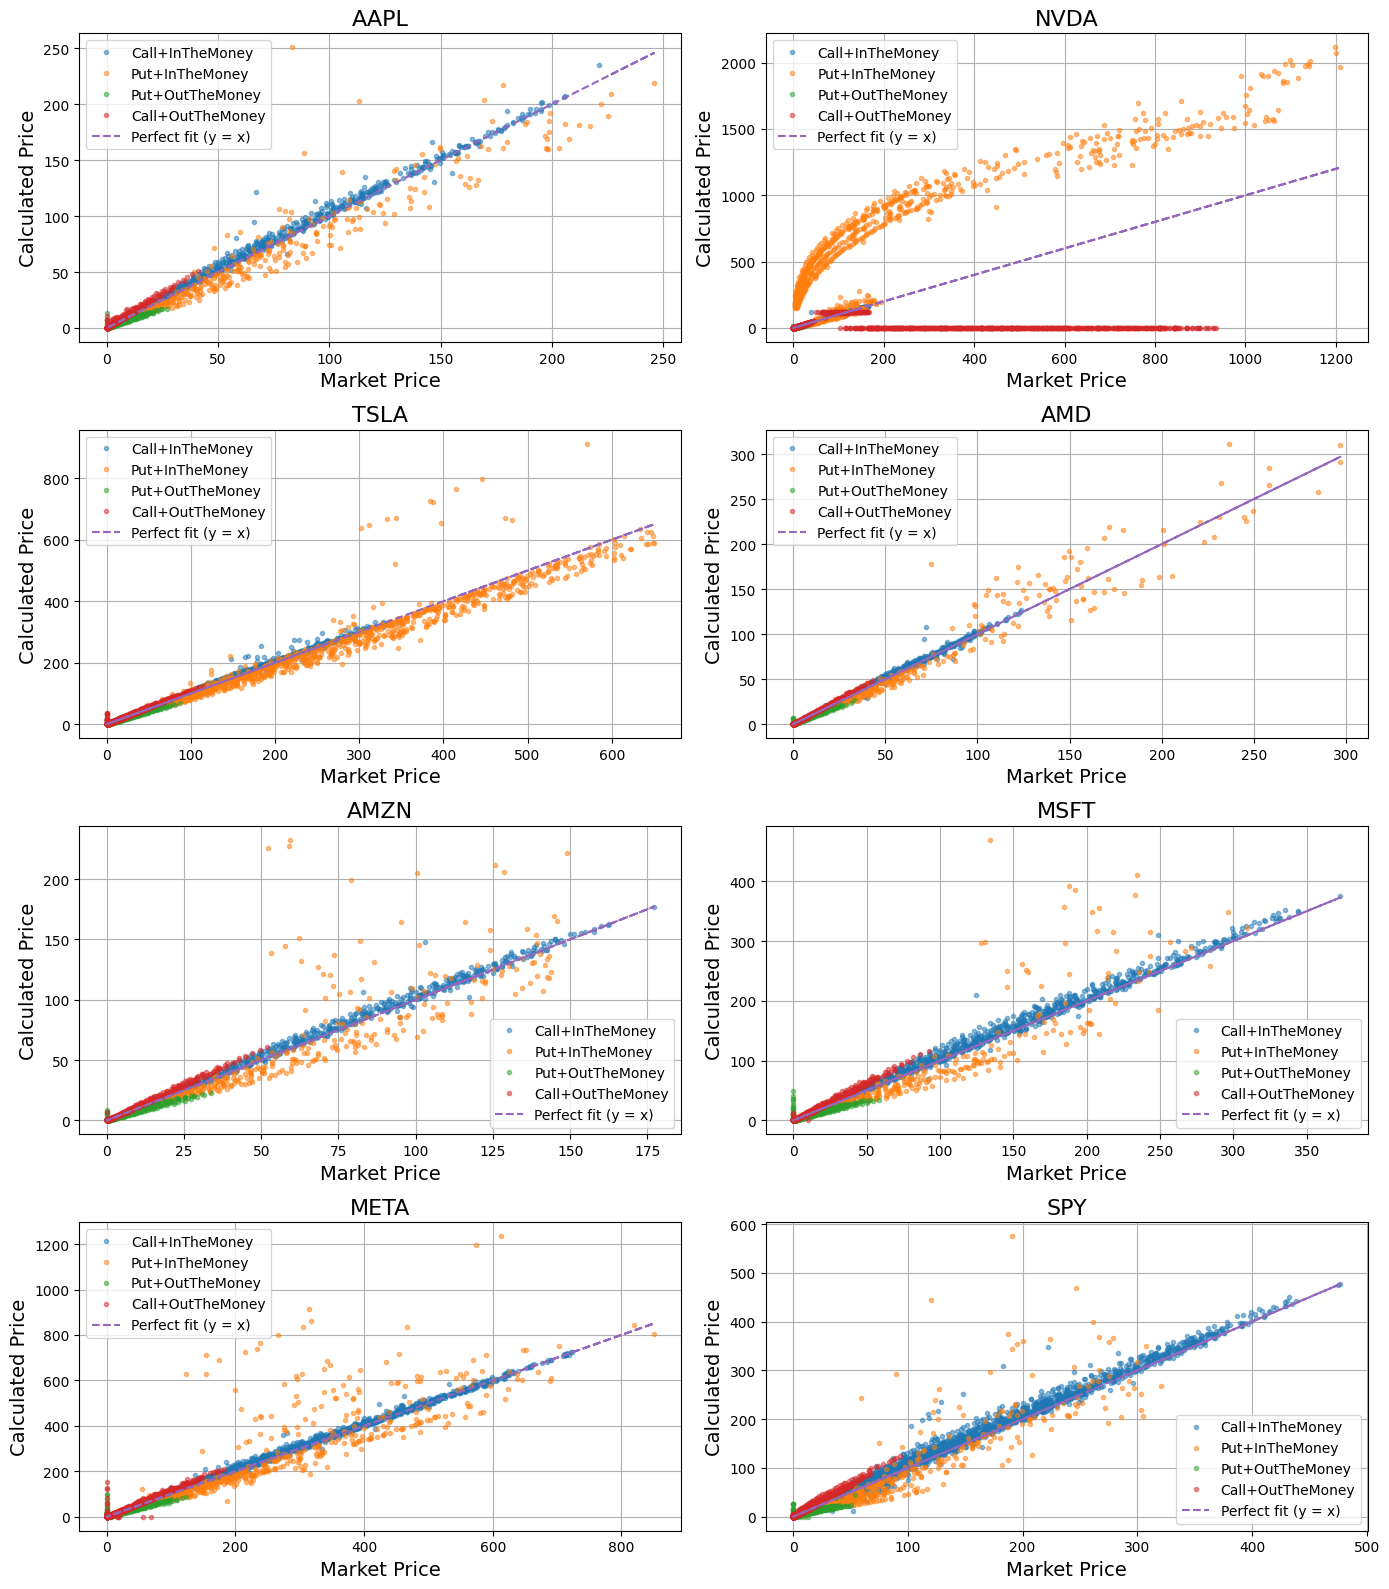

In [43]:
tickers = ["AAPL","NVDA","TSLA","AMD","AMZN","MSFT","META","SPY"]

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()  # Flatten to easily index with a loop

for i, ticker in enumerate(tickers):
    ax = axes[i]

    stock_options = options_df.loc[options_df["stockTicker"]==ticker]

    ax.plot(stock_options.loc[(stock_options["isCall"] == 1) & (stock_options["inTheMoney"] == 1), "lastPrice"],stock_options.loc[(stock_options["isCall"] == 1) & (stock_options["inTheMoney"] == 1), "calculated_price"],'.',label="Call+InTheMoney",alpha=0.5)
    ax.plot(stock_options.loc[(stock_options["isCall"] == 0) & (stock_options["inTheMoney"] == 1), "lastPrice"],stock_options.loc[(stock_options["isCall"] == 0) & (stock_options["inTheMoney"] == 1), "calculated_price"],'.',label="Put+InTheMoney",alpha=0.5)
    ax.plot(stock_options.loc[(stock_options["isCall"] == 0) & (stock_options["inTheMoney"] == 0), "lastPrice"],stock_options.loc[(stock_options["isCall"] == 0) & (stock_options["inTheMoney"] == 0), "calculated_price"],'.',label="Put+OutTheMoney",alpha=0.5)
    ax.plot(stock_options.loc[(stock_options["isCall"] == 1) & (stock_options["inTheMoney"] == 0), "lastPrice"],stock_options.loc[(stock_options["isCall"] == 1) & (stock_options["inTheMoney"] == 0), "calculated_price"],'.',label="Call+OutTheMoney",alpha=0.5)
    ax.plot(stock_options["lastPrice"], stock_options["lastPrice"], "--", label="Perfect fit (y = x)")
    ax.set_title(f"{ticker}", fontsize=16)
    ax.set_xlabel("Market Price", fontsize=14)
    ax.set_ylabel("Calculated Price", fontsize=14)
    ax.legend()
    ax.grid(True)

# plt.legend()
plt.tight_layout()
plt.savefig("../plots/BS_Market_Comparison_CallsPuts_InOutTheMoney.png")

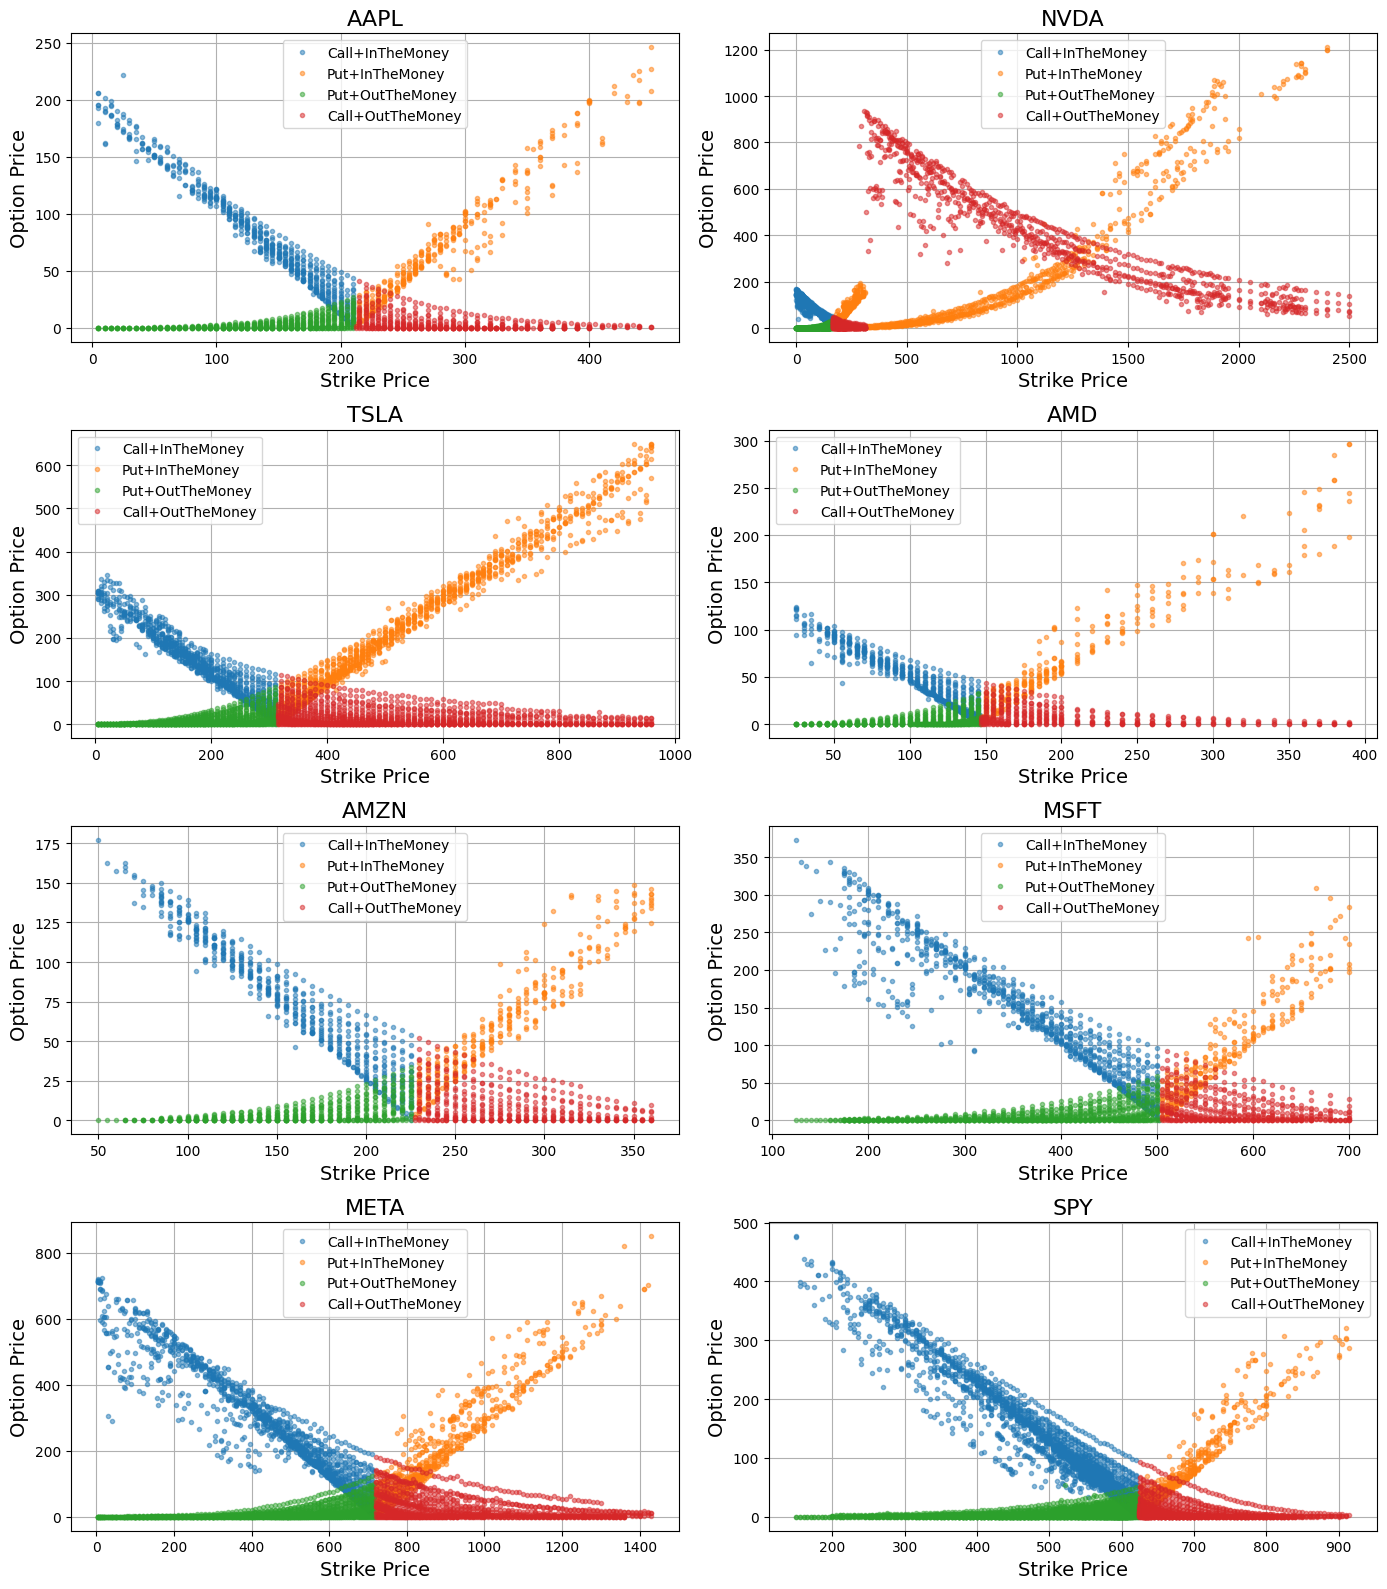

In [40]:
tickers = ["AAPL","NVDA","TSLA","AMD","AMZN","MSFT","META","SPY"]

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()  # Flatten to easily index with a loop

for i, ticker in enumerate(tickers):
    ax = axes[i]

    stock_options = options_df.loc[options_df["stockTicker"]==ticker]

    ax.plot(stock_options.loc[(stock_options["isCall"] == 1) & (stock_options["inTheMoney"] == 1), "strike"],stock_options.loc[(stock_options["isCall"] == 1) & (stock_options["inTheMoney"] == 1), "lastPrice"],'.',label="Call+InTheMoney",alpha=0.5)
    ax.plot(stock_options.loc[(stock_options["isCall"] == 0) & (stock_options["inTheMoney"] == 1), "strike"],stock_options.loc[(stock_options["isCall"] == 0) & (stock_options["inTheMoney"] == 1), "lastPrice"],'.',label="Put+InTheMoney",alpha=0.5)
    ax.plot(stock_options.loc[(stock_options["isCall"] == 0) & (stock_options["inTheMoney"] == 0), "strike"],stock_options.loc[(stock_options["isCall"] == 0) & (stock_options["inTheMoney"] == 0), "lastPrice"],'.',label="Put+OutTheMoney",alpha=0.5)
    ax.plot(stock_options.loc[(stock_options["isCall"] == 1) & (stock_options["inTheMoney"] == 0), "strike"],stock_options.loc[(stock_options["isCall"] == 1) & (stock_options["inTheMoney"] == 0), "lastPrice"],'.',label="Call+OutTheMoney",alpha=0.5)
    # ax.plot(stock_options["lastPrice"], stock_options["lastPrice"], "--", label="Perfect fit (y = x)")
    ax.set_title(f"{ticker}", fontsize=16)
    ax.set_ylabel("Option Price", fontsize=14)
    ax.set_xlabel("Strike Price", fontsize=14)
    ax.legend()
    ax.grid(True)

# plt.legend()
plt.tight_layout()
plt.savefig("../plots/Strike_Option_CallsPuts_InOutTheMoney.png")